### Imports et initialisations

In [36]:
import numpy as np
import random
from tensorflow import keras
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from clustertools import *

In [37]:
#répertoire dans lequel seront stockés les clusters, doit se terminer obligatoirement par /
cluster_dir = "clusters/1M_Min_clusters/"

clean_dataset_file = "datasets/MillionTweetsMin_NEFU.txt"
raw_dataset_file = "datasets/MillionTweets_NEFU.txt"

### Chargement des données en mémoire

In [38]:
with open(clean_dataset_file, "r") as file:
    lines = file.readlines()
    
# On sépare les messages pour les avoir sous forme de liste de mots.
clean_dataset = [line.split() for line in lines]

with open(raw_dataset_file, "r") as file:
    raw_dataset = file.read().splitlines()

### Création des échantillons
Ne pas exécuter pour travailler avec toutes les données

In [5]:
sample_size = 5000

idx_list = random.sample(range(len(clean_dataset)), sample_size)
clean_dataset = [clean_dataset[i] for i in idx_list]
raw_dataset = [raw_dataset[i] for i in idx_list]

### Encodage du jeu de données

On charge le modèle depuis le disque

In [39]:
from gensim.models import KeyedVectors

In [40]:
model = KeyedVectors.load("models/w2vec_model_d300_global_Min")
dim = 300

In [41]:
# Encode un message
# msg : liste de chaînes de caractères correspondant aux mots du message
# model : le modèle utilisé pour l'encodage
# dim : la dimension des vecteurs mots dans ce modèle
# Renvoie un vecteur qui est la moyenne de tous les vecteurs correspondants aux mots du message
# Si aucun mot du message n'est dans le modèle, renvoie un vecteur de zéros.
def encode(msg, model, dim):
    return np.mean([model[word] for word in msg if word in model] or [np.zeros(dim)], axis = 0)

In [42]:
%%time
#encodage de l'échantillon pour créer le jeu de données
dataset_encoded = np.array([encode(msg, model, dim) for msg in clean_dataset])

CPU times: user 32.1 s, sys: 528 ms, total: 32.6 s
Wall time: 32.6 s


### Visualisation du dataset

- On réalise une réduction de dimension afin de visualiser les données dans une grille en deux dimensions
- On utilise pour cela les parties encodeur de nos trois autoencodeurs
- Puis on compare avec PCA

#### Premier autoencodeur (une seule couche cachée)

In [11]:
autoencoder1 = keras.models.load_model("models/ae_Min_1")
inp = keras.Input(shape=(300,))
outp = autoencoder1.layers[1](inp)
encoder1 = keras.Model(inp, outp)

In [43]:
%%time
two_dim_dataset1 = encoder1.predict(dataset_encoded)

CPU times: user 18.2 s, sys: 1.8 s, total: 20 s
Wall time: 12.4 s


In [44]:
T1 = two_dim_dataset1.T

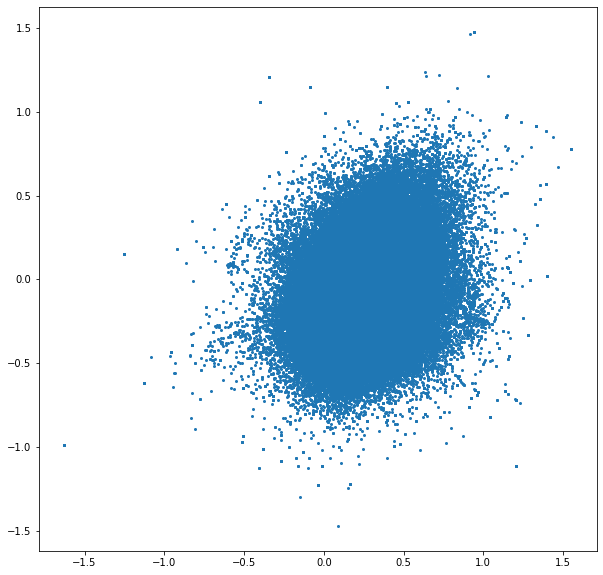

In [45]:
#Affichage des données
plt.scatter(T1[0], T1[1], marker='.')
plt.show()

#### Deuxième autoencodeur (trois couches cachées)

In [16]:
autoencoder2 = keras.models.load_model("models/ae_Min_3")
inp = keras.Input(shape=(300,))
outp = autoencoder2.layers[1](inp)
outp = autoencoder2.layers[2](outp)
encoder2 = keras.Model(inp, outp)

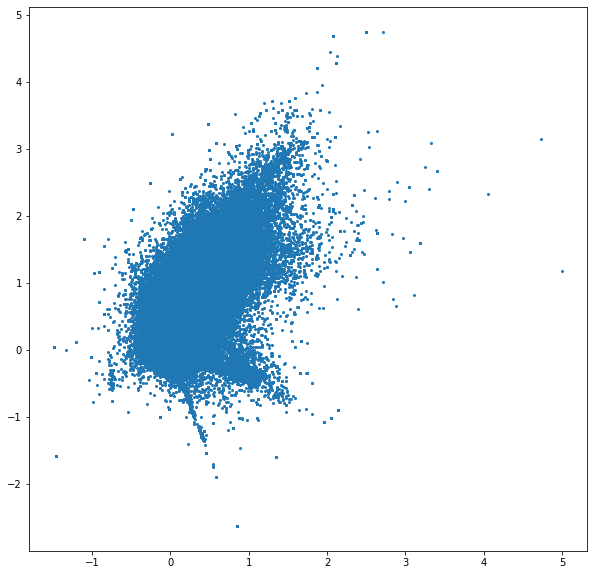

CPU times: user 21 s, sys: 2.03 s, total: 23 s
Wall time: 14.5 s


In [46]:
%%time
two_dim_dataset2 = encoder2.predict(dataset_encoded)
T2 = two_dim_dataset2.T
#Affichage des données
plt.scatter(T2[0], T2[1], marker='.')
plt.show()

#### Troisième autoencodeur (cinq couches cachées)

In [18]:
autoencoder3 = keras.models.load_model("models/ae_Min_5")
inp = keras.Input(shape=(300,))
outp = autoencoder3.layers[1](inp)
outp = autoencoder3.layers[2](outp)
outp = autoencoder3.layers[3](outp)
encoder3 = keras.Model(inp, outp)

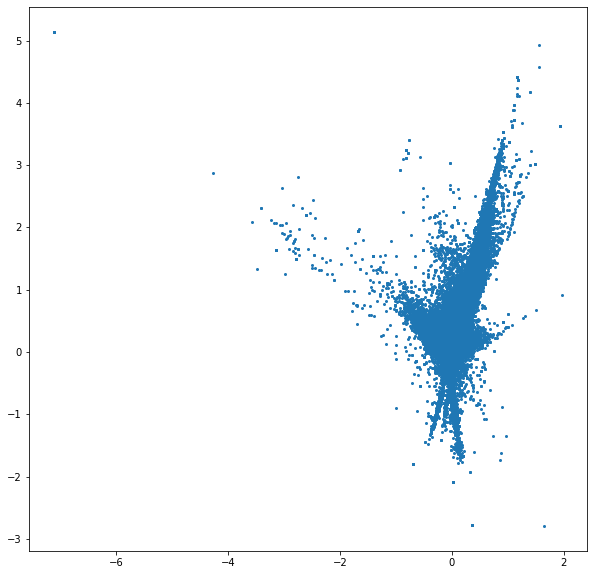

CPU times: user 22.2 s, sys: 2.02 s, total: 24.3 s
Wall time: 15.3 s


In [47]:
%%time
two_dim_dataset3 = encoder3.predict(dataset_encoded)
T3 = two_dim_dataset3.T
#Affichage des données
plt.scatter(T3[0], T3[1], marker='.')
plt.show()

#### Comparaison avec PCA

In [48]:
%%time

pca = PCA(n_components=2)

#On crée une version en deux dimensions de notre jeu de données
pca_two_dim_dataset = pca.fit_transform(dataset_encoded)

CPU times: user 43.9 s, sys: 15.6 s, total: 59.5 s
Wall time: 10.2 s


In [49]:
#On utilise la matrice transposée de notre jeu de données pour pouvoir visualiser les données
pca = pca_two_dim_dataset.T

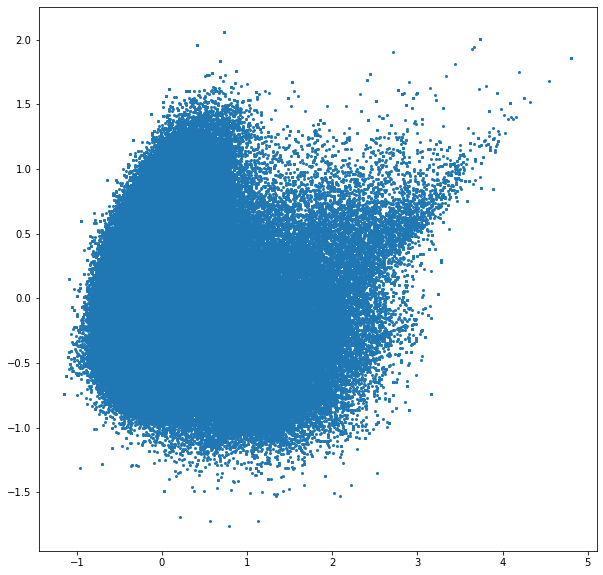

In [50]:
#Affichage des données
plt.scatter(pca[0], pca[1], marker='.')
plt.show()

### Clustering avec Kmeans

Pour mémoire : méthode de calcul du nombre idéal de clusters avec la méthode du coude (elbow method)
```python
sum_of_squared_dist = []
for k in range(1, 60):
    km = KMeans(n_clusters=k)
    km.fit(dataset_encoded)
    sum_of_squared_dist.append(km.inertia_)
    
plt.plot(range(1, 60), sum_of_squared_dist, 'bx-')
plt.show
```

In [51]:
n_clust = 10

In [52]:
%%time
km_model = KMeans(n_clusters=n_clust, random_state=0)
kmeans = km_model.fit(dataset_encoded)

CPU times: user 17min 53s, sys: 15.1 s, total: 18min 8s
Wall time: 2min 30s


In [53]:
%%time 
km_pred = kmeans.predict(dataset_encoded)

CPU times: user 1.41 s, sys: 3.14 ms, total: 1.41 s
Wall time: 390 ms


In [54]:
%%time
km_centers = [[r[0] for r in model.similar_by_vector(center)] for center in km_model.cluster_centers_]

CPU times: user 776 ms, sys: 189 ms, total: 965 ms
Wall time: 174 ms


In [55]:
# Initialisation des variables globales pour le module clustertools
init_globals(clean_dataset, raw_dataset, two_dim_dataset1, cluster_dir)

In [56]:
%%time
res, wlists, mlists, cmlists, e2dmlists, mfw, hkw, clust_n_msg = parse(km_pred)

CPU times: user 17.7 s, sys: 73.1 ms, total: 17.8 s
Wall time: 17.8 s


### Visualisation des clusters avec les différentes méthodes

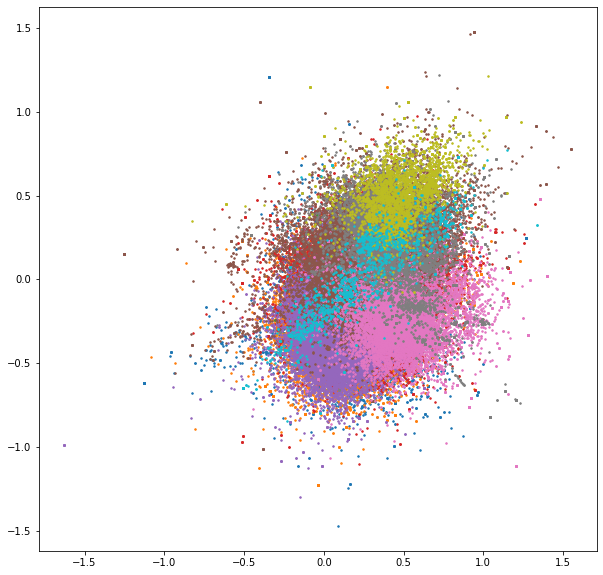

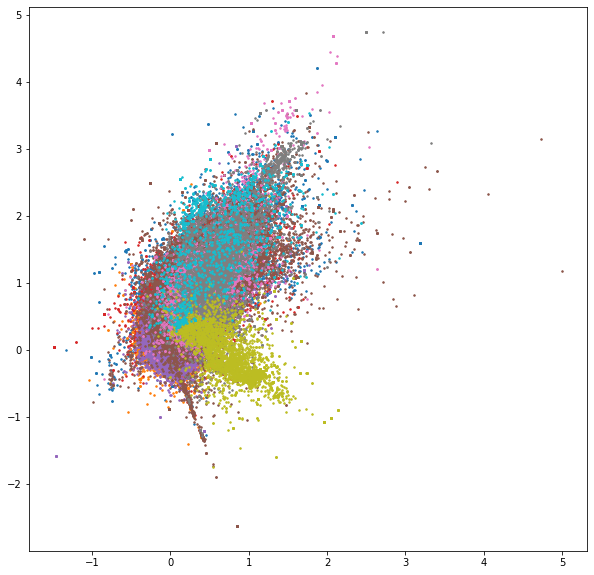

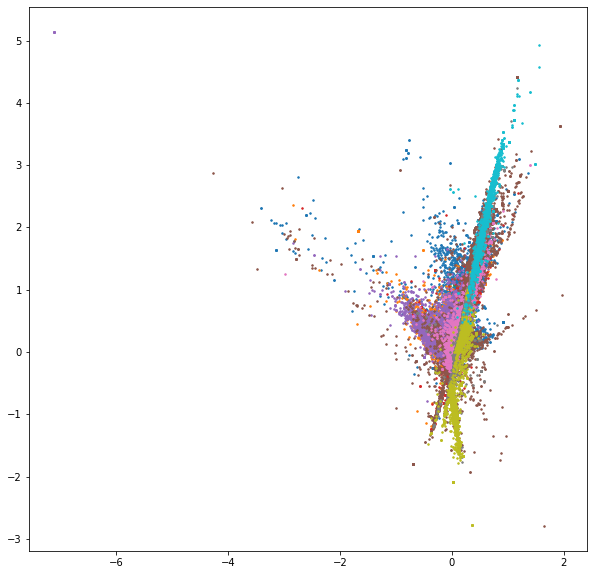

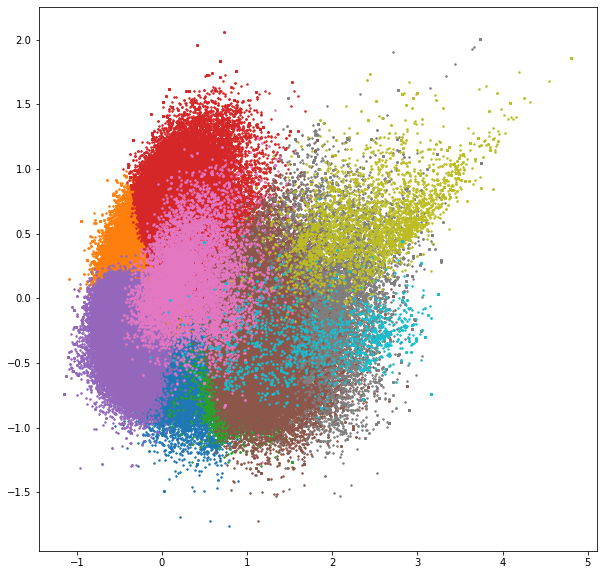

In [62]:
plt.rcParams["lines.markersize"] = 3

plot_results(res, two_dim_dataset1)
plot_results(res, two_dim_dataset2)
plot_results(res, two_dim_dataset3)
plot_results(res, pca_two_dim_dataset)